# Свёрточная сеть для распознавания объектов в PyTorch

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
device

device(type='cuda')

## Задание гиперпараметров

In [83]:
num_epochs = 20
batch_size = 4
learning_rate = 0.001
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

## Подготовка данных

In [28]:
train = CIFAR10(root='./cifar10', train=True, transform=transform, download=False) 
test = CIFAR10(root='./cifar10', train=False, transform=transform, download=False) 

In [59]:
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

In [19]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [49]:
def myimshow(img):
    img = img / 2 + 0.5  # денормализовать
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

### Примеры входных данных

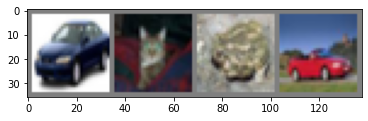

In [123]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

myimshow(torchvision.utils.make_grid(images))

## Создание и обучение модели

### Задание модели

In [55]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # входной слой: 3 канала на входе, 6 каналов на выходе, размер ядра 5
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # -> n, 3, 32, 32
        x = self.pool(F.relu(self.conv1(x)))  # -> n, 6, 14, 14
        x = self.pool(F.relu(self.conv2(x)))  # -> n, 16, 5, 5
        x = x.view(-1, 16 * 5 * 5)            # -> n, 400
        x = F.relu(self.fc1(x))               # -> n, 120
        x = F.relu(self.fc2(x))               # -> n, 84
        x = self.fc3(x)                       # -> n, 10
        return x

### Создание модели, задание функции потерь и оптимизатора

In [84]:
model = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### Цикл обучения

In [85]:
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/20], Loss: 2.3206
Epoch [2/20], Loss: 1.4930
Epoch [3/20], Loss: 1.2015
Epoch [4/20], Loss: 2.2810
Epoch [5/20], Loss: 0.9174
Epoch [6/20], Loss: 1.0880
Epoch [7/20], Loss: 2.1169
Epoch [8/20], Loss: 1.9805
Epoch [9/20], Loss: 2.1198
Epoch [10/20], Loss: 1.3672
Epoch [11/20], Loss: 0.6310
Epoch [12/20], Loss: 0.6769
Epoch [13/20], Loss: 1.7766
Epoch [14/20], Loss: 1.4672
Epoch [15/20], Loss: 0.1898
Epoch [16/20], Loss: 0.9421
Epoch [17/20], Loss: 2.8373
Epoch [18/20], Loss: 0.4515
Epoch [19/20], Loss: 0.9183
Epoch [20/20], Loss: 1.0524


### Расчёт точности

In [86]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

Accuracy of the network: 63.68 %


## Демонстрация работы нейронной сети

Prediction = horse, actual = horse


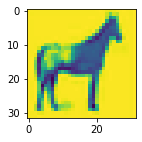

In [122]:
# вывести изображение и предсказание нейросети
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=True)
to_predict = iter(test_loader)
sample, label = to_predict.next()
output = model(sample.to(device))
_, prediction = torch.max(output, 1)
plt.figure(figsize = (5,2))
plt.imshow(sample[0][0])
print(f'Prediction = {classes[prediction[0].item()]}, actual = {classes[label[0].item()]}')